In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("dependencies")
from music21 import *
from music21.repeat import Expander
from gensim.models import FastText
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import warnings

%matplotlib inline
%config InlineBackend.figure_format='retina'

from src.ssm_helper import *

sns.set_style("whitegrid")

warnings.filterwarnings("ignore")

SSM Code is based on exercise session materials

In [2]:
sample_score = converter.parse("data/asap-dataset/Schubert/Impromptu_op.90_D.899/3/xml_score.musicxml") # converter is from the music21 package
# linearized_sample_score = sample_score.expandRepeats() # "Unfolds" repeat measures. Important for visualizing repetitions!
linearized_sample_score = sample_score
# linearized_sample_score.show()

In [3]:
# Cast notes as MIDI note numbers
midi_sequence = []

for event in linearized_sample_score.recurse().notes:
    try:
        midi_sequence.append(event.pitch.midi)
    except:
        pass


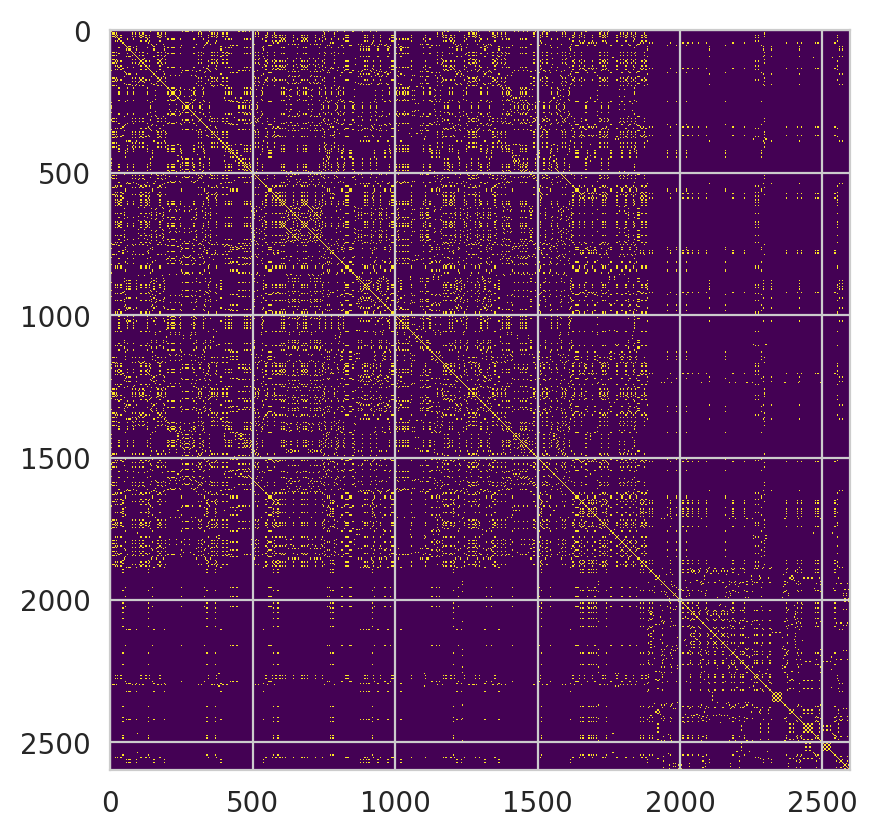

In [4]:

# Kronecker function for upcoming matrix (do not modify)
self_sim_mat1 = calculate_ssm(midi_sequence, kronecker_delta)

# Display the SSM - there should be a bright diagonal running f rom the top left to the bottom right
plt.imshow(self_sim_mat1, cmap='viridis', interpolation='nearest')
# plt.xticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
# plt.yticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.show()

In [5]:
# Cast measures as lists of MIDI note numbers

midi_measure_sequence = []
## STUDENT SECTION - REMOVE ALL OR SOME OF CODE ##
for measure in linearized_sample_score.getElementsByClass(stream.Part)[0].getElementsByClass(stream.Measure):
    measure_midi_list = []
    for event in measure.recurse().notes:
        try:
            measure_midi_list.append(event.pitch.midi)
        except:
            if isinstance(event, chord.Chord):
                for pitch in event.pitches:
                    measure_midi_list.append(pitch.midi)
    midi_measure_sequence.append(measure_midi_list)

# join measures 69/70 and 81/82 -- fixes bug in measure numbers
m69 = midi_measure_sequence[68] + midi_measure_sequence[69]
m81 = midi_measure_sequence[80] + midi_measure_sequence[81]

midi_measure_sequence[80] = m81
midi_measure_sequence.pop(81)
midi_measure_sequence[68] = m69
midi_measure_sequence.pop(69)

print(len(midi_measure_sequence))

86


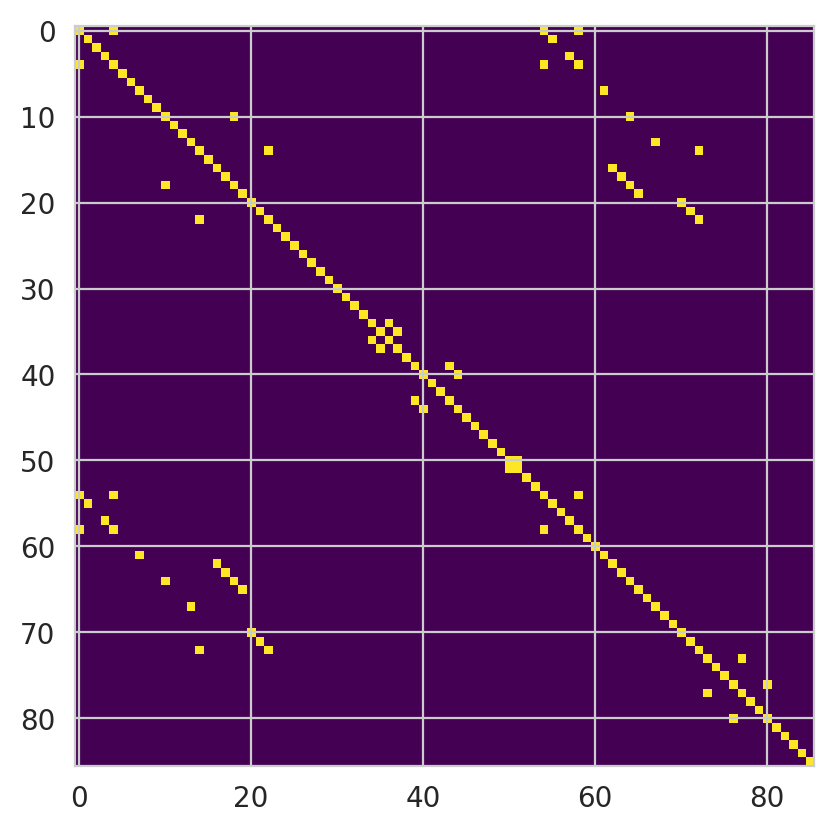

In [6]:
# Create similarity matrix from MIDI measure lists
self_sim_mat2_kron = calculate_ssm(midi_measure_sequence, kronecker_delta)

plt.imshow(self_sim_mat2_kron, cmap='viridis', interpolation='nearest')
# plt.xticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
# plt.yticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
plt.show()

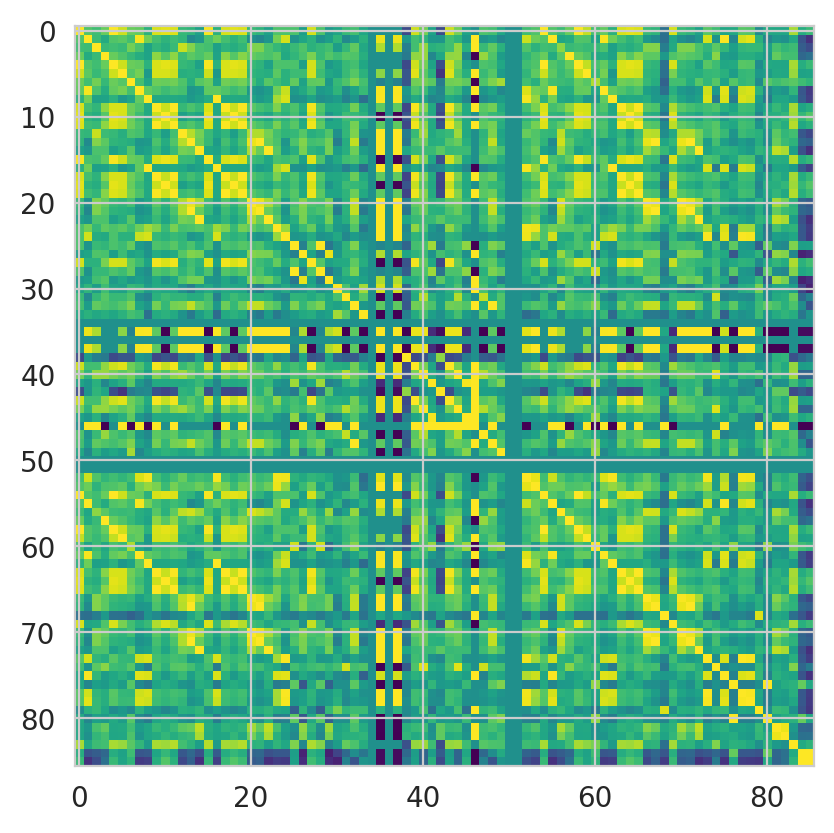

In [7]:
self_sim_mat2_corr = calculate_ssm(midi_measure_sequence, calculate_correlation)

plt.imshow(self_sim_mat2_corr, cmap='viridis', interpolation='nearest')
# plt.xticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
# plt.yticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
plt.show()

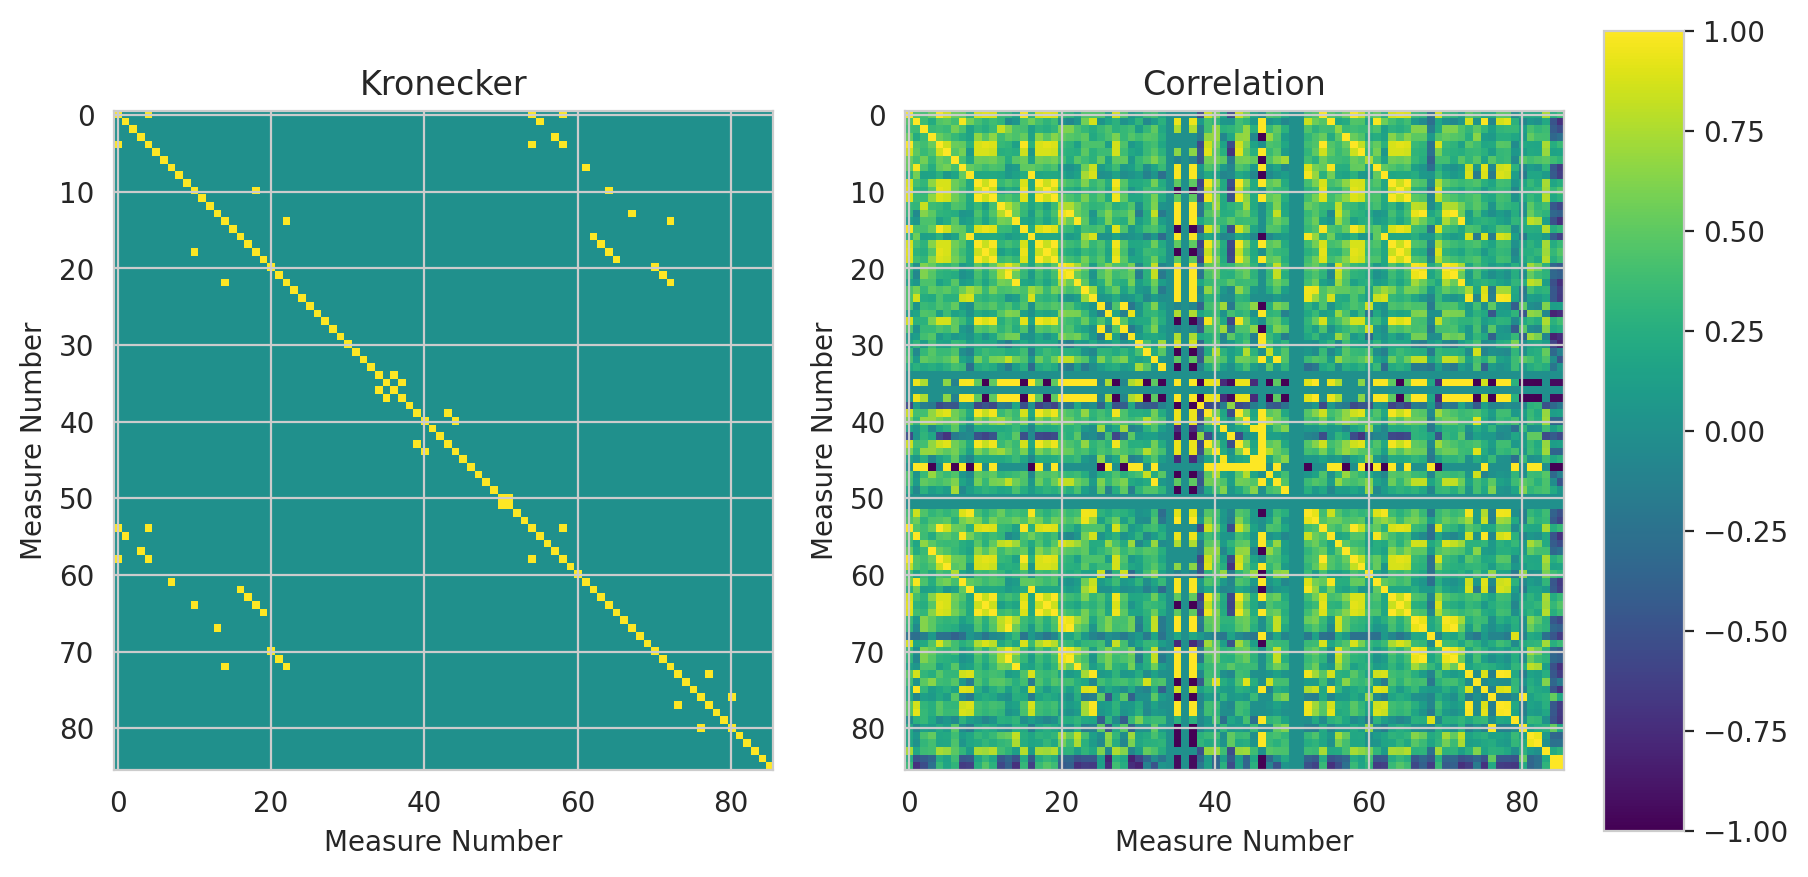

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

im1 = axes[0].imshow(self_sim_mat2_kron, vmin=-1, vmax=1, cmap='viridis', interpolation='nearest')
im2 = axes[1].imshow(self_sim_mat2_corr, vmin=-1, vmax=1, cmap='viridis', interpolation='nearest')

axes[0].set_xlabel("Measure Number")
axes[1].set_xlabel("Measure Number")
axes[0].set_ylabel("Measure Number")
axes[1].set_ylabel("Measure Number")

axes[0].set_title("Kronecker")
axes[1].set_title("Correlation")

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.3, 0.04, 0.4])
fig.colorbar(im2, cax=cbar_ax)
#fig.tight_layout()

plt.savefig("report/matrix.pdf", dpi=600, bbox_inches='tight', pad_inches=0)

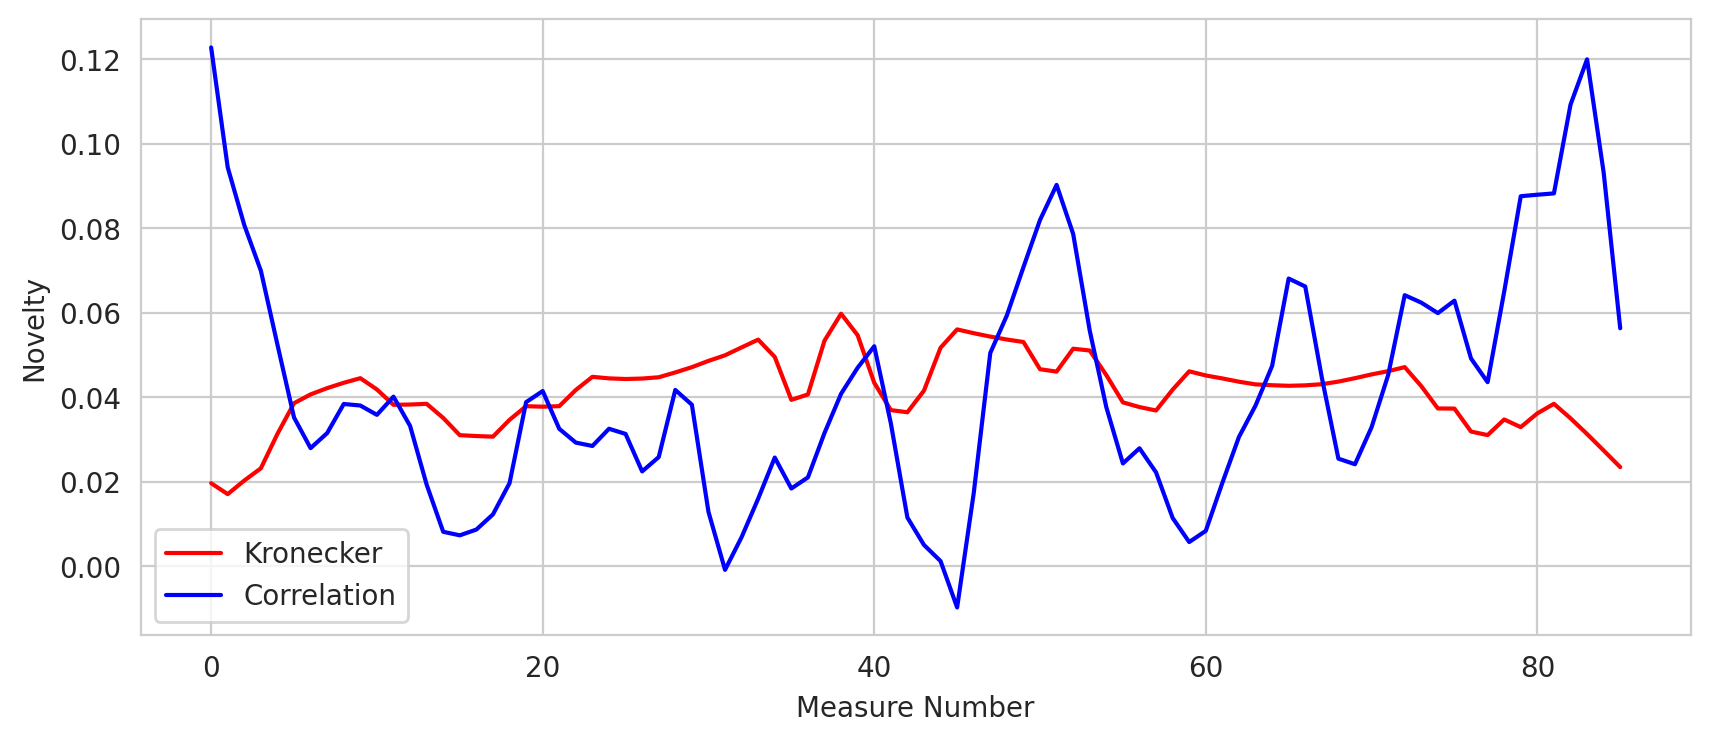

In [35]:
L_kernel = 16
nov_kron = compute_novelty_ssm(self_sim_mat2_kron, L=L_kernel, exclude=False)
nov_corr = compute_novelty_ssm(self_sim_mat2_corr, L=L_kernel, exclude=False)   


plt.figure(figsize=(10, 4))
plt.plot(nov_kron, color="red", label="Kronecker")
plt.plot(nov_corr, color="blue", label="Correlation")
plt.ylabel('Novelty')
plt.xlabel('Measure Number')
plt.legend()
plt.savefig("report/novelty.pdf", dpi=600)

In [10]:
get_novelty_topk(nov_kron, 10)

array([32, 33, 37, 38, 39, 45, 46, 49, 52, 53])

In [11]:
get_novelty_topk(nov_corr, 10)

array([ 0, 49, 50, 51, 65, 72, 79, 80, 82, 83])

In [43]:
get_novelty_threshold(nov_kron, 0.037)

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 81])

In [58]:
get_novelty_threshold(nov_corr, 0.03)

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 19, 20, 21, 24, 25,
       28, 29, 37, 38, 39, 40, 41, 47, 48, 49, 50, 51, 52, 53, 54, 62, 63,
       64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
       83, 84, 85])

In [46]:
get_novelty_threshold(-nov_corr, -0.030)

array([ 6, 13, 14, 15, 16, 17, 18, 22, 23, 26, 27, 30, 31, 32, 33, 34, 35,
       36, 42, 43, 44, 45, 46, 55, 56, 57, 58, 59, 60, 61, 68, 69])

## Create TikZ

In [15]:
from src.phrase_tikz import convert_list_to_tikz

In [62]:
kronecker_version = get_novelty_threshold(nov_kron, 0.037)

convert_list_to_tikz(kronecker_version, "alg_kron_phrases.tex")

In [61]:
correlation_version = get_novelty_threshold(nov_corr, 0.03)

convert_list_to_tikz(correlation_version, "alg_corr_phrases.tex")